This notebook contains model composition, training and optimization. Please refer to another repository notebook for ETL procedure and associated code.

Please note: The training of this algorithm was conducted remotely via Google Colab. As such, the county data was uploaded in memory for the session. The cleaned county data resulting from the ETL process mentioned above and utilized for this model can be found within the repository's 'Resource' directory titled, "County_Final_With_Outcomes_And_Segments.csv".

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
!pip install keras-tuner
import keras_tuner as kt
import joblib
!pip install shap
import shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.5 MB/s eta 0:00:00


In [2]:
# Import the cleaned county dataset
county_data = pd.read_csv("County_Final_With_Outcomes_And_Segments.csv")
county_data


,Year,County,% Male,% Female,% Male > 18 Years Old,% Female > 18 Years Old,% White,% Black or African American,% American Indian and Alaska Native,% Asian,...,Nonveteran Labor Force Participation Rate (%),Nonveteran Unemployment Rate (%),% Nonveteran Population With Income Below Poverty Level (Past 12 Months),% Nonveteran Population With Any Disability,Birth Rate Per 1000 Women (15-19 Years Old),Birth Rate Per 1000 Women (20-34 Years Old),Birth Rate Per 1000 Women (35-50 Years Old),Received Public Assistance Income Rate Per 1000 Women (Past 12 Months),winning_party D:0 R:1,Segment
0,2012,ADAMS,0.492,0.508,0.486,0.514,0.964249,0.020429,0.005107,0.010215,...,0.801,0.055,0.086,0.151,82.0,100.0,14.0,99.0,1,1
1,2012,ALLEGHENY,0.480,0.520,0.473,0.527,0.815505,0.142296,0.006869,0.035329,...,0.783,0.074,0.118,0.141,11.0,83.0,19.0,184.0,0,1
2,2012,ARMSTRONG,0.496,0.504,0.493,0.507,0.977205,0.013875,0.005946,0.002973,...,0.750,0.085,0.122,0.192,38.0,90.0,5.0,155.0,1,0
3,2012,BEAVER,0.483,0.517,0.477,0.523,0.913300,0.074877,0.004926,0.006897,...,0.786,0.083,0.100,0.162,40.0,121.0,15.0,26.0,1,0
4,2012,BERKS,0.491,0.509,0.484,0.516,0.907676,0.063278,0.010373,0.018672,...,0.796,0.095,0.127,0.142,13.0,109.0,20.0,174.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2020,SCHUYLKILL,0.515,0.485,0.513,0.487,0.946429,0.039683,0.005952,0.007937,...,0.726,0.048,0.113,0.186,9.0,159.0,25.0,64.0,1,0
116,2020,SOMERSET,0.522,0.478,0.524,0.476,0.951819,0.032448,0.008850,0.006883,...,0.702,0.026,0.097,0.189,113.0,162.0,44.0,102.0,1,0
117,2020,WASHINGTON,0.491,0.509,0.486,0.514,0.934378,0.047013,0.003918,0.014691,...,0.774,0.049,0.097,0.185,0.0,97.0,7.0,110.0,1,1
118,2020,WESTMORELAND,0.491,0.509,0.485,0.515,0.947835,0.035433,0.003937,0.012795,...,0.786,0.042,0.100,0.163,13.0,98.0,31.0,17.0,1,1


In [3]:
# Drop the non-determinant categorical values from our dataset ('County')
county_data.drop(columns=['County'], inplace=True)


# Train vs. Test Data Splitting and Scaling

In [4]:
# Split our preprocessed data into features and target/outcome arrays
y = county_data['winning_party D:0 R:1']
X = county_data.drop(columns='winning_party D:0 R:1')

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)


In [5]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler on training data
X_scaler = scaler.fit(X_train)

# Scale the features training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Model Compilation, Training & Evaluation

In [6]:
# Define the deep learning neural network
input_feature_layers = len(X_train.columns)
hidden_nodes_layer_one = 80
hidden_nodes_layer_two = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer_one, activation="relu", input_dim=input_feature_layers))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer_two, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 80)                  │           8,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           2,430 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,701 (41.80 KB)

 Trainable params: 10,701 (41.80 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [8]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5897 - loss: 0.6887
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7711 - loss: 0.5396 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8591 - loss: 0.4172 
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8725 - loss: 0.3458
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8780 - loss: 0.3465 
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9126 - loss: 0.2766 
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9260 - loss: 0.2501 
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9237 - loss: 0.2349  
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9449 - loss: 0.1980  
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9543 - loss: 0.2014
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9426 - loss: 0.1944 
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9850

In [9]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


1/1 - 1s - 513ms/step - accuracy: 0.9667 - loss: 0.1034
Loss: 0.10340830683708191, Accuracy: 0.9666666388511658


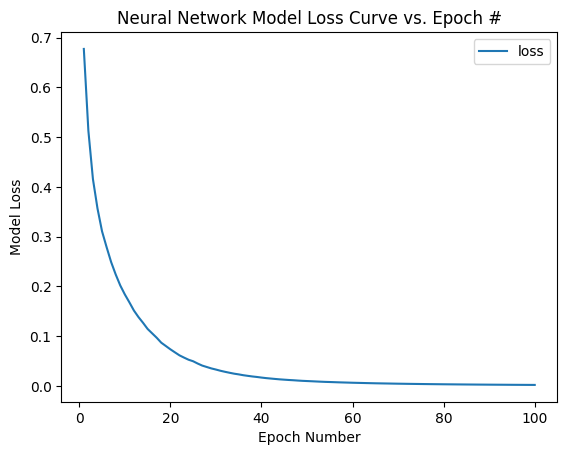

In [10]:
# Graphically evaluate the model via the "loss" metric
history_df = pd.DataFrame(fit_model.history)

# Increment the index by 1 to match epoch number
history_df.index += 1

# Corresponding "loss" metric plot
history_df.plot(y="loss")
plt.xlabel("Epoch Number")
plt.ylabel("Model Loss")
plt.title("Neural Network Model Loss Curve vs. Epoch #")
plt.savefig('Initial_Model_Loss.png', format='png')
plt.show()


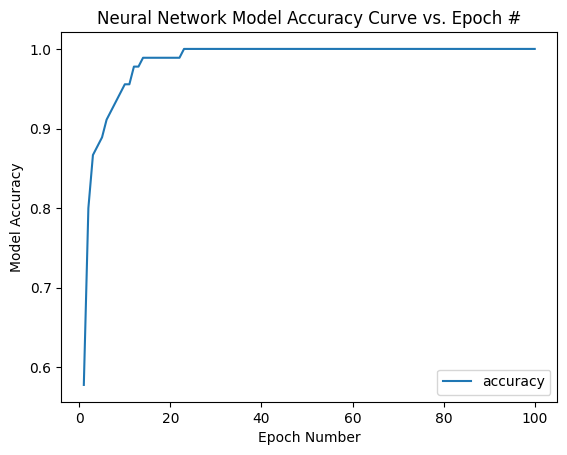

In [11]:
# Conduct the same evaluation as above but now for the accuracy metric
history_df.plot(y="accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Model Accuracy")
plt.title("Neural Network Model Accuracy Curve vs. Epoch #")
plt.savefig('Initial_Model_Accuracy.png', format='png')
plt.show()


In [12]:
# Saving intial trained model
nn.save('Initial_Model.keras')


# Model Optimization via Keras Tuner

In [13]:
# Define a function that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=43,
        max_value=129,
        step=43), activation=activation, input_dim=102))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=43,
            max_value=129,
            step=43),
            activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [14]:
# Instantiate Keras Tuner instance
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Execute the Keras Tuner search for optimal hyperparameters
tuner.search(X_train_scaled, y_train,epochs=20, validation_data=(X_test_scaled,y_test))


Trial 60 Complete [00h 00m 06s]
val_accuracy: 0.8999999761581421

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 04m 45s


In [16]:
# Obtain the optimal model hyperparameters
optimal_hyperparameters = tuner.get_best_hyperparameters(1)[0]
optimal_hyperparameters.values


{'activation': 'relu',
 'first_units': 129,
 'num_layers': 4,
 'units_0': 86,
 'units_1': 86,
 'units_2': 129,
 'units_3': 129,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0042',
 'units_4': 43}

In [17]:
# Evaluate the retrieved optimal model against entire test data set
optimal_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = optimal_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


1/1 - 0s - 312ms/step - accuracy: 1.0000 - loss: 0.0387
Loss: 0.03866763412952423, Accuracy: 1.0


In [18]:
# Saving Keras Tuner optimized model (not retrained)
optimal_model.save("Optimized_Model.keras")

# Saving the optimized model scaler to a file for future predictions
joblib.dump(scaler, 'Optimized_Model_Scaler.pkl')


['Optimized_Model_Scaler.pkl']

In [19]:
# Utilize SHAP (SHapley Additive exPlanations) to determine feature importance for the optimized model
# Create the explainer (with train set) and generate SHAP values for the test set
explainer = shap.KernelExplainer(optimal_model.predict, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/30 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6334/6334 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━

In [20]:
# Convert SHAP values to a DataFrame
shap_values_array = shap_values[:, :, 0].squeeze()
features_list = X_train.columns
shap_df = pd.DataFrame(shap_values_array, columns=features_list)

# Calculate the mean absolute SHAP value for each feature
mean_shap_values = np.abs(shap_df).mean(axis=0)

# Create a DataFrame to hold feature importance
importance_df = pd.DataFrame({
    'Feature': features_list,
    'Mean SHAP Value': mean_shap_values
})

# Descending sort of the DataFrame by Mean SHAP Value
importance_df = importance_df.sort_values(by='Mean SHAP Value', ascending=False)

# Displaying the top 10 features by feature importance as determined by the mean SHAP value
# These are the top 10 most influential features in driving the model's predicitions towards a 1 or Republican outcome
top_10_features = importance_df.head(10)
top_10_features


,Feature,Mean SHAP Value
% White,% White,0.044912
Birth Rate Per 1000 Women (20-34 Years Old),Birth Rate Per 1000 Women (20-34 Years Old),0.028114
% Asian,% Asian,0.026172
% Bachelors Degree or Higher (25-34),% Bachelors Degree or Higher (25-34),0.025799
% Bachelors Degree or Higher (18-24),% Bachelors Degree or Higher (18-24),0.023439
% Black or African American,% Black or African American,0.021904
Veteran Labor Force Participation Rate (%),Veteran Labor Force Participation Rate (%),0.021861
% Total Population 65-74 Years Old,% Total Population 65-74 Years Old,0.019115
% Bachelors Degree or Higher (65 & Older),% Bachelors Degree or Higher (65 & Older),0.017557
% Male,% Male,0.016821


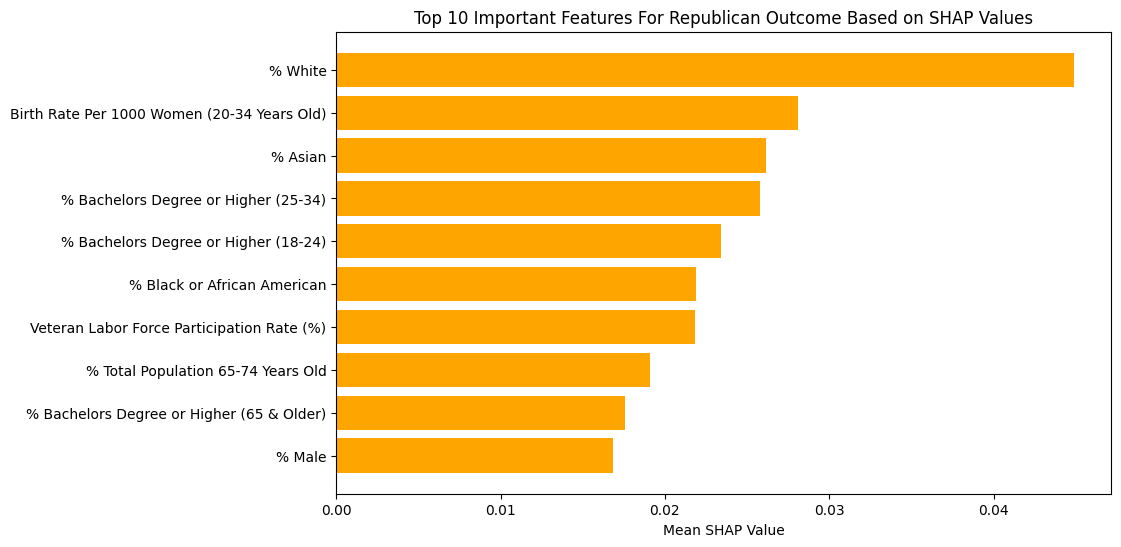

In [21]:
# Visualize the top 10 feature importance DataFrame graphically and export
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Mean SHAP Value'], color='orange')
plt.xlabel('Mean SHAP Value')
plt.title('Top 10 Important Features For Republican Outcome Based on SHAP Values')
plt.gca().invert_yaxis()
plt.savefig('Optimized_Model_Top_10_Feature_Importance.png', format='png')
plt.show()


In [22]:
# Retreiving and display the bottom 10 features by feature importance as determined by the mean SHAP value
# These are the 10 least influential features in driving the model's predicitions towards a 1 or Republican outcome and may potentially push outocmes towards a 0 or Democratic outcome
bottom_10_features = importance_df.tail(10)
bottom_10_features


,Feature,Mean SHAP Value
"% Nonfamily Households $15,000-$24,999","% Nonfamily Households $15,000-$24,999",0.004285
% Total Population With Income Below Poverty Level (Past 12 Months),% Total Population With Income Below Poverty L...,0.004234
Nonveteran Labor Force Participation Rate (%),Nonveteran Labor Force Participation Rate (%),0.004025
"% Households $150,000-$199,999","% Households $150,000-$199,999",0.003995
"% Married Couple Families $150,000-$199,999","% Married Couple Families $150,000-$199,999",0.003675
"% Families $150,000-$199,999","% Families $150,000-$199,999",0.003556
Median Married Couple Families Income ($),Median Married Couple Families Income ($),0.003517
% American Indian and Alaska Native,% American Indian and Alaska Native,0.003180
Mean Household Income ($),Mean Household Income ($),0.003139
Median Household Income ($),Median Household Income ($),0.002222


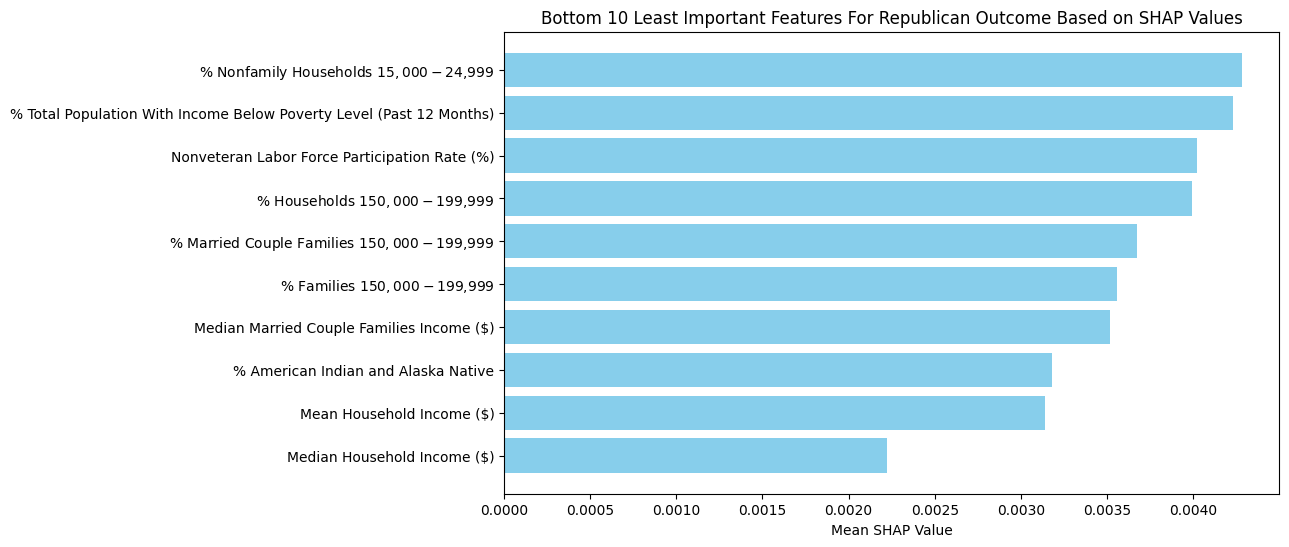

In [23]:
# Visualize the bottom 10 feature importance DataFrame graphically and export
plt.figure(figsize=(10, 6))
plt.barh(bottom_10_features['Feature'], bottom_10_features['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean SHAP Value')
plt.title('Bottom 10 Least Important Features For Republican Outcome Based on SHAP Values')
plt.gca().invert_yaxis()
plt.savefig('Optimized_Model_Bottom_10_Feature_Importance.png', format='png')
plt.show()


In [24]:
# Retrain the hyperparameter optimized model to obtain model history for graphical visualization of loss and accuracy performance
optimal_model_with_history = create_model(optimal_hyperparameters)
optimized_fit_model = optimal_model_with_history.fit(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test))


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.4848 - loss: 0.6839 - val_accuracy: 0.7000 - val_loss: 0.5843
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8402 - loss: 0.5378 - val_accuracy: 0.8667 - val_loss: 0.4829
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8803 - loss: 0.4103 - val_accuracy: 0.8667 - val_loss: 0.4018
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9187 - loss: 0.3028 - val_accuracy: 0.8333 - val_loss: 0.3426
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9087 - loss: 0.2547 - val_accuracy: 0.8667 - val_loss: 0.2934
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9260 - loss: 0.1878 - val_accuracy: 0.8667 - val_loss: 0.2676
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9733 - loss: 0.1365 - val_accuracy: 0.8667 - val_loss: 0.2903
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9811 - loss: 0.0853 - val_accuracy: 0.8667 - val_loss: 0.2975
Epoch 9/20

In [25]:
# Evaluate the optimized model using the test data
model_loss, model_accuracy = optimal_model_with_history.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


1/1 - 0s - 25ms/step - accuracy: 0.9000 - loss: 0.2534
Loss: 0.2533864378929138, Accuracy: 0.8999999761581421


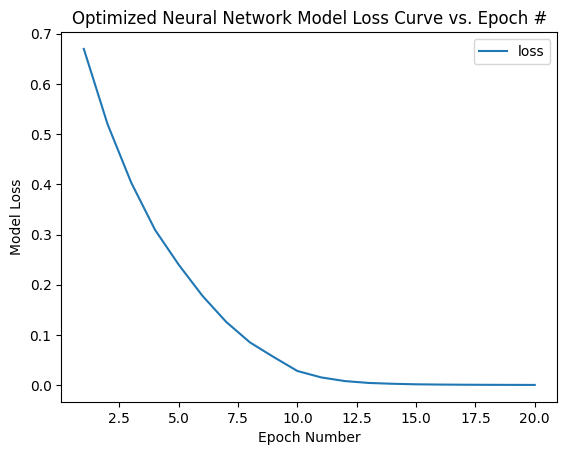

In [26]:
# Graphically evaluate the optimized model via the "loss" metric
optimized_history_df = pd.DataFrame(optimized_fit_model.history)

# Increment the index by 1 to match epoch number
optimized_history_df.index += 1

# Corresponding "loss" metric plot
optimized_history_df.plot(y="loss")
plt.xlabel("Epoch Number")
plt.ylabel("Model Loss")
plt.title("Optimized Neural Network Model Loss Curve vs. Epoch #")
plt.savefig('Optimized_Model_Loss.png', format='png')
plt.show()


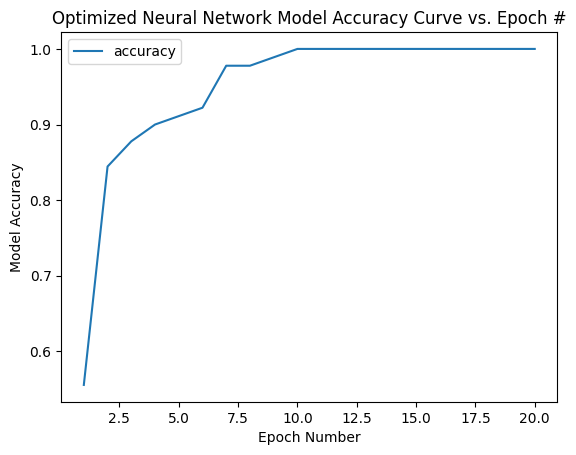

In [27]:
# Conduct the same evaluation as above but now for the accuracy metric of the optimized model
optimized_history_df.plot(y="accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Model Accuracy")
plt.title("Optimized Neural Network Model Accuracy Curve vs. Epoch #")
plt.savefig('Optimized_Model_Accuracy.png', format='png')
plt.show()


In [28]:
# Saving optimized trained model
optimal_model_with_history.save('Optimized_Model_Retrained.keras')
